# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [1]:
import numpy as np
import pandas as pd
import re
import os.path
from os import makedirs
import glob
from parse_results import process_results_xml

In [2]:
sert_results_dir = 'OneDrive//Results - PowerEdge'
bios_setting_file = 'test_settings.csv'
cpu_metrics_dir = 'cpu_data'

working_dir = 'data'
all_data_file = 'all_data.csv'
overwrite_data = True

# Generate and load the data (Run Once)

In [3]:
sert_data = pd.DataFrame()

if not os.path.isdir(working_dir):
    os.makedirs(working_dir, exist_ok=True)


if not os.path.isfile(f'{working_dir}//{all_data_file}') or overwrite_data:

    metrics_data = pd.DataFrame()
    test_details = pd.DataFrame()
    scores = pd.DataFrame()
    invalid_results = []   # List of skipped results because they're invalid

    for f in glob.glob(f'{sert_results_dir}//**//results.xml', recursive=True):
        try:
            # Name of test directory -- sert-xxxx
            test_name = os.path.basename(os.path.dirname(f))

            if os.path.isfile(f'{sert_results_dir}//{test_name}//invalid.png'):
                invalid_results.append(test_name)
                continue
            
            # Load the SERT result
            metrics, score, env = process_results_xml(f)

            file_df = pd.DataFrame.from_records(metrics)
            # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
            calibrations = file_df.loc[file_df['loadlevel']=='calibration', ['worklet', 'score']]
            calibrations = calibrations.rename(columns={'score': 'calibration-score'})

            file_df = pd.merge(file_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
            file_df['actual-load'] = file_df['score'] / file_df['calibration-score']
            file_df['test-name'] = test_name

            score_df = pd.DataFrame.from_records(score)
            score_df['test-name'] = test_name

            metrics_data = metrics_data.append(file_df, ignore_index=True)
            test_details = test_details.append(pd.DataFrame.from_records(env, index=[test_name]))
            scores = scores.append(score_df, ignore_index=True)

        except Exception as e:
            print(f, ': FAILED TO LOAD -- ', e, type(e))
    
    if len(invalid_results) > 0:    
        print(f'Invalid results skipped: {invalid_results}')

    # Load external details for test
    if bios_setting_file != '' and os.path.isfile(bios_setting_file):
        settings = pd.read_csv(bios_setting_file, index_col=0)
    else:
        settings = pd.DataFrame()
    settings.columns = ['location', 'bios']
    test_details = pd.merge(test_details, settings, left_index=True, right_index=True)
    # TODO: Add pressure lookup here for tunnel tests

    # Join metrics and test details to results.
    sert_data = pd.merge(metrics_data, scores, how='left', on=['test-name', 'worklet', 'loadlevel', 'workload', 'score', 'watts-avg'])
    sert_data = pd.merge(sert_data, test_details, left_on='test-name', right_index=True)
    sert_data.loc[sert_data['workload'] == 'Idle', 'actual-load'] = 0


    # Store generated data
    metrics_data.to_csv(f'{working_dir}//sert_metrics.csv', index=False)
    test_details.to_csv(f'{working_dir}//test_details.csv')
    scores.to_csv(f'{working_dir}//scores.csv', index=False)
    sert_data.to_csv(f'{working_dir}//{all_data_file}', index=False)
    
else:
    print(f'Loading SERT data fromo disk')
    sert_data = pd.read_csv(f'{working_dir}//{all_data_file}', parse_dates=['start', 'end'], index_col=0)
    
sert_data.describe()
        

OneDrive//Results - PowerEdge/sert-0101/results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
OneDrive//Results - PowerEdge/sert-0106/results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'find' <class 'AttributeError'>
OneDrive//Results - PowerEdge/sert-0142/results.xml : FAILED TO LOAD --  time data '2021-08-07T12:48:25+01:00' does not match format '%Y-%m-%dT%H:%M:%Sf%z' <class 'ValueError'>
OneDrive//Results - PowerEdge/sert-0030/results.xml : FAILED TO LOAD --  'NoneType' object has no attribute 'text' <class 'AttributeError'>
Invalid results skipped: ['sert-0129', 'sert-0077', 'sert-0056', 'sert-0131', 'sert-0099', 'sert-0096', 'sert-0035', 'sert-0111', 'sert-0108', 'sert-0094', 'sert-0041', 'sert-0107', 'sert-0070', 'sert-0092', 'sert-0132', 'sert-0143', 'sert-0027', 'sert-0105', 'sert-0128', 'sert-0034', 'sert-0036', 'sert-0073', 'sert-0082', 'sert-0104', 'sert-0098', 'sert-0033', 'sert-0095', 'sert-0059', 'sert-0031', 

,score,watts-min,watts-max,watts-avg,temp-min,temp-max,temp-avg,calibration-score,actual-load,norm-score,ref-score,efficiency-score
count,3.436000e+03,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3436.000000,3.024000e+03,3100.000000,3360.000000,3360.000000,3360.000000
mean,3.151559e+05,269.198056,280.759872,274.354266,23.007149,23.048858,23.028974,4.634310e+05,0.610215,3.434636,90131.503500,12.303119
std,5.913839e+05,103.835658,106.651372,105.495981,1.976494,1.981493,1.978645,7.286263e+05,0.296060,2.871747,136023.367609,8.458332
min,0.000000e+00,67.550000,69.590000,68.368525,20.000000,20.062500,20.035714,1.922230e+02,0.000000,0.471334,11.520000,2.095409
25%,5.319811e+03,184.382500,196.812500,188.649677,21.312500,21.312500,21.312500,3.054941e+04,0.373639,1.613484,5437.512500,7.972011
50%,4.647146e+04,264.705000,275.120000,268.058710,22.875000,22.937500,22.910714,8.950737e+04,0.503380,3.092490,15946.510000,10.723267
75%,2.438346e+05,356.720000,372.687500,366.150449,24.062500,24.062500,24.062500,3.585636e+05,0.876912,4.348993,81279.882500,15.027831
max,4.142241e+06,493.500000,504.600000,495.164516,29.375000,29.375000,29.375000,2.344183e+06,1.048051,27.970126,354112.340000,106.013770


# Efficiency and Power consumption

Todo: 
- Generate previous graphs for efficiency and power against load
- Fit basic curves to each

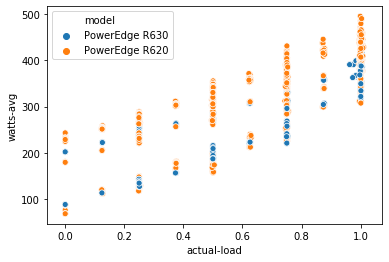

In [4]:
import seaborn as sns

cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['cpu'].str.contains('2690')]

sns.scatterplot('actual-load', 'watts-avg', hue='model', data=cpu)

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?

In [5]:
cpu_metrics = pd.DataFrame()

if not os.path.exists(f'{working_dir}//cpu_metrics.csv') or overwrite_data :
    
    for f in glob.glob(f'{cpu_metrics_dir}//**.csv', recursive=True):
    #     try:
        samples = pd.read_csv(f, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
        if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
            # Final row contains "Session end:"
            samples.drop('Session end:', inplace=True)
            samples.index = pd.to_datetime(samples.index)

        cpu_metrics = cpu_metrics.append(samples)
    #     except:
    #         print(f'FAILED LOADING FILE: {f}')

    cpu_metrics.sort_index(inplace=True)
    cpu_metrics['total cpu power'] = cpu_metrics['CPU 0 Power'] + cpu_metrics['CPU 1 Power']
    
    cpu_metrics.to_csv(f'{working_dir}//cpu_metrics.csv')
    
else:
    cpu_metrics = read_csv(f'{working_dir}//cpu_metrics.csv', index_col='Time', parse_dates=['Time'])
    

/home/steve/miniconda3/envs/basicds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#pd.to_datetime(cpu_metrics['Time']
sert_data['cpu-power'] = sert_data.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['chassis-power'] = sert_data['watts-avg'] - sert_data['cpu-power']

In [30]:
#full_details['chassis_power'].describe()

cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['bios'] == 'Efficiency']
cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]

cpu.head()

,loadlevel,worklet,score,workload,watts-min,watts-max,watts-avg,start,end,temp-min,...,dimm_size_mb,dimms,model,psu,ref,vendor,location,bios,cpu-power,chassis-power
205,100%,Compress,30271.709784,CPU,438.90,452.60,443.819355,2021-07-28 13:37:07.926000+01:00,2021-07-28 13:38:08.535000+01:00,24.6875,...,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.,Tabletop,Efficiency,271.866667,171.952688
206,75%,Compress,22844.695314,CPU,303.75,323.56,310.717419,2021-07-28 13:38:20.816000+01:00,2021-07-28 13:39:21.160000+01:00,24.6250,...,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.,Tabletop,Efficiency,185.466667,125.250752
207,50%,Compress,15188.133266,CPU,194.59,200.56,198.038065,2021-07-28 13:39:33.394000+01:00,2021-07-28 13:40:33.707000+01:00,24.6250,...,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.,Tabletop,Efficiency,107.250000,90.788065
208,25%,Compress,7610.104983,CPU,144.77,146.77,145.445484,2021-07-28 13:40:45.988000+01:00,2021-07-28 13:41:46.302000+01:00,24.5625,...,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.,Tabletop,Efficiency,69.283333,76.162151
209,100%,CryptoAES,243455.753218,CPU,429.90,452.70,440.722581,2021-07-28 13:47:05.353000+01:00,2021-07-28 13:48:05.722000+01:00,24.5000,...,8192,8,PowerEdge R620,750,R620-HighP-MidT,Dell Inc.,Tabletop,Efficiency,264.816667,175.905914


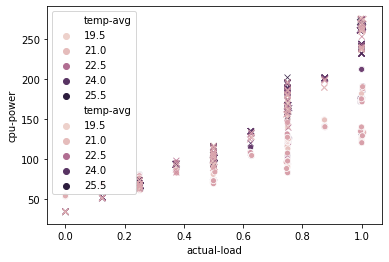

In [31]:
sns.scatterplot('actual-load', 'chassis-power', data=cpu, hue='temp-avg')
sns.scatterplot('actual-load', 'cpu-power', data=cpu, marker='x', hue='temp-avg')

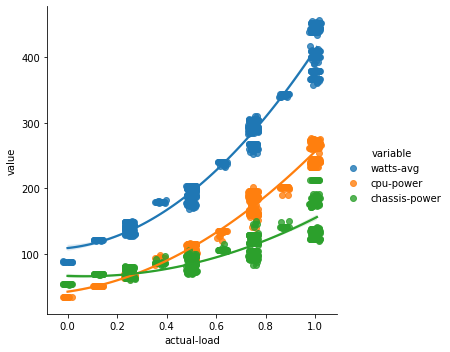

In [32]:
plotdf = cpu.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2, x_jitter=0.02)

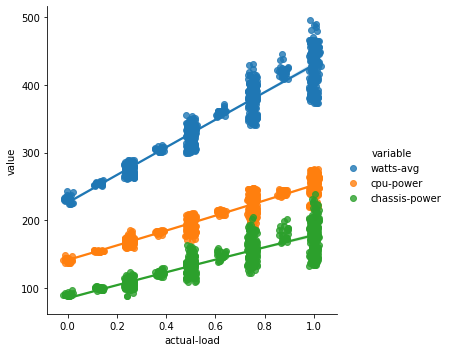

In [33]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['bios'] == 'Performance']
cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]

plotdf = cpu.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2, x_jitter=0.02)

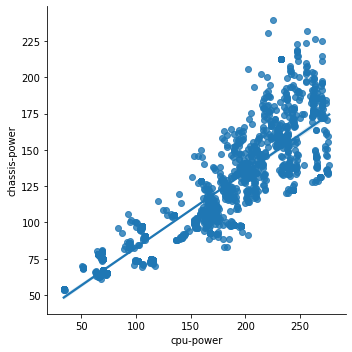

In [37]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
#cpu = cpu[cpu['bios'] == 'Efficiency']
cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]


sns.lmplot(x='cpu-power', y='chassis-power', data=cpu, order=1)